<a href="https://colab.research.google.com/github/natitedros/WAVN-Federated-Learning/blob/main/CNN_edge_data_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, Input


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
CSV_PATH = '/content/drive/MyDrive/gazebo_dataset_fl/labels.csv'
IMG_DIR = '/content/drive/MyDrive/gazebo_dataset_fl/images/'
EDGE_DIR = '/content/drive/MyDrive/gazebo_dataset_fl/edges/'
EDGE_CTRD_DIR = '/content/drive/MyDrive/gazebo_dataset_fl/edges_centroid/'

In [5]:
df = pd.read_csv(CSV_PATH)
print(f"Total samples: {len(df)}")
print(f"\nFirst few rows:\n{df.head()}")
print(f"\nDirection counts:\n{df['direction'].value_counts()}")

Total samples: 121

First few rows:
          current_image     destination_image direction
0      0001_current.png  0001_destination.png   forward
1      0002_current.png  0002_destination.png  backward
2      0003_current.png  0003_destination.png     right
3  0003_destination.png      0003_current.png      left
4      0004_current.png  0004_destination.png   forward

Direction counts:
direction
right       31
forward     30
backward    30
left        30
Name: count, dtype: int64


In [6]:
direction_map = {'forward': 0, 'backward': 1, 'left': 2, 'right': 3}
df['direction_label'] = df['direction'].map(direction_map)
shard_size = len(df)
print(f"first few rows after direction mapping:\n{df.head()}")

first few rows after direction mapping:
          current_image     destination_image direction  direction_label
0      0001_current.png  0001_destination.png   forward                0
1      0002_current.png  0002_destination.png  backward                1
2      0003_current.png  0003_destination.png     right                3
3  0003_destination.png      0003_current.png      left                2
4      0004_current.png  0004_destination.png   forward                0


In [7]:
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

shard = df_shuffled.iloc[:]

# For each shard create train/val split
train_df, val_df = train_test_split(shard, test_size=0.2, random_state=42)


In [8]:
# Function to load image
def load_image(img_path):
    img = load_img(img_path, target_size=(128, 128))
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

In [9]:
# Creating the dataset
def create_dataset(dataframe, image_dir, batch_size=32):
    current_images = []
    dest_images = []
    labels = []
    suffix = ''
    if image_dir == EDGE_DIR:
        suffix = '_hed'
    elif image_dir == EDGE_CTRD_DIR:
        suffix = '_hed_c'

    for idx, row in dataframe.iterrows():
        current_img = load_image(image_dir + row['current_image'][:-4] + suffix + '.png')
        dest_img = load_image(image_dir + row['destination_image'][:-4] + suffix + '.png')

        current_images.append(current_img)
        dest_images.append(dest_img)
        labels.append(row['direction_label'])

    current_images = np.array(current_images)
    dest_images = np.array(dest_images)
    labels = np.array(labels)

    return current_images, dest_images, labels

In [10]:
print("Loading training data...")
X_train_current, X_train_dest, y_train = create_dataset(train_df, IMG_DIR)

X_train_current_hed, X_train_dest_hed, y_train_hed = create_dataset(train_df, EDGE_DIR)

X_train_current_hed_c, X_train_dest_hed_c, y_train_hed_c = create_dataset(train_df, EDGE_CTRD_DIR)

print("Loading validation data...")
X_val_current, X_val_dest, y_val = create_dataset(val_df, IMG_DIR)

X_val_current_hed, X_val_dest_hed, y_val_hed = create_dataset(val_df, EDGE_DIR)

X_val_current_hed_c, X_val_dest_hed_c, y_val_hed_c = create_dataset(val_df, EDGE_CTRD_DIR)

print(f"\nTraining data shapes:")
print(f"Current images: {X_train_current.shape}")
print(f"Destination images: {X_train_dest.shape}")
print(f"Labels: {y_train.shape}")

Loading training data...
Loading validation data...

Training data shapes:
Current images: (96, 128, 128, 3)
Destination images: (96, 128, 128, 3)
Labels: (96,)


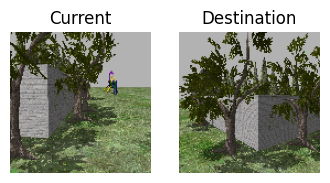

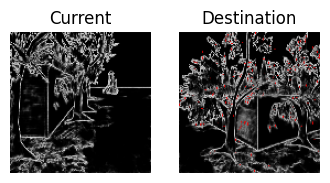

Direction: 2


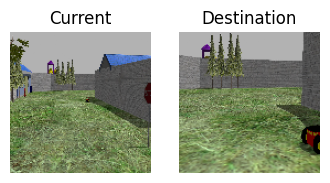

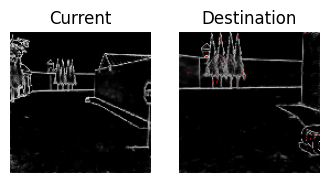

Direction: 0


In [ ]:
import matplotlib.pyplot as plt

def show_pair(idx):
    plt.figure(figsize=(4,4))

    # show current image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_current[idx])
    plt.title("Current")
    plt.axis('off')

    # show destination image
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_dest[idx])
    plt.title("Destination")
    plt.axis('off')

    plt.show()

    plt.figure(figsize=(4,4))
    # show current image
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_current_hed[idx])
    plt.title("Current")
    plt.axis('off')

    # show destination image
    plt.subplot(1, 2, 2)
    plt.imshow(X_train_dest_hed_c[idx])
    plt.title("Destination")
    plt.axis('off')

    plt.show()

    print(f"Direction: {y_train[idx]}")

# show a few random samples
for i in [0, 5]:
    show_pair(i)


In [ ]:
from tensorflow.keras import layers, models

def create_model(num_classes=4):
    # Inputs
    current_input = layers.Input(shape=(128,128, 3), name='current_image')
    dest_input = layers.Input(shape=(128, 128, 3), name='destination_image')

    # Simple CNN branch
    def cnn_branch(x):
        x = layers.Conv2D(32, 3, activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(64, 3, activation="relu")(x)
        x = layers.MaxPooling2D()(x)
        x = layers.Conv2D(128, 3, activation="relu")(x)
        x = layers.GlobalAveragePooling2D()(x)
        return x

    # Both branches
    current_features = cnn_branch(current_input)
    dest_features = cnn_branch(dest_input)

    # Combine
    combined = layers.concatenate([current_features, dest_features])

    # Dense layers
    x = layers.Dense(16, activation='relu')(combined)
    output = layers.Dense(num_classes, activation='softmax')(x)

    # Model
    model = models.Model(inputs=[current_input, dest_input], outputs=output)
    return model


In [ ]:
model = []
for i in range(3):
    model.append(create_model(num_classes=4))
model[0].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ current_image       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ destination_image   │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ current_image[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 126, 126,  │        896 │ destination_imag… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 63, 63,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 61, 61,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 30, 30,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 28,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ conv2d_5[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │      4,112 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │         68 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 190,676 (744.83 KB)

 Trainable params: 190,676 (744.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
for i in range(3):
    model[i].compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [ ]:
# Training the model
history = model[0].fit(
    [X_train_current, X_train_dest],
    y_train,
    validation_data=([X_val_current, X_val_dest], y_val),
    epochs=15,
    batch_size=8
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 432ms/step - accuracy: 0.2723 - loss: 1.3945 - val_accuracy: 0.2400 - val_loss: 1.3938
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 436ms/step - accuracy: 0.2457 - loss: 1.3883 - val_accuracy: 0.2000 - val_loss: 1.3897
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 498ms/step - accuracy: 0.2545 - loss: 1.3876 - val_accuracy: 0.2000 - val_loss: 1.3904
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 397ms/step - accuracy: 0.2294 - loss: 1.3875 - val_accuracy: 0.2000 - val_loss: 1.3903
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 555ms/step - accuracy: 0.2674 - loss: 1.3850 - val_accuracy: 0.2000 - val_loss: 1.3922
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 393ms/step - accuracy: 0.2568 - loss: 1.3850 - val_accuracy: 0.2000 - val_loss: 1.3901
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 394ms/step - accuracy: 0.2810 - loss: 1.3848 - val_accuracy: 0.2000 - val_loss: 1.3897
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 525ms/step - accuracy: 0.1922 - loss: 1.3897 - val_accuracy: 0.

In [ ]:
# Training the hed model
history = model[1].fit(
    [X_train_current_hed, X_train_dest_hed],
    y_train_hed,
    validation_data=([X_val_current_hed, X_val_dest_hed], y_val_hed),
    epochs=15,
    batch_size=8
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 509ms/step - accuracy: 0.2284 - loss: 1.4008 - val_accuracy: 0.3200 - val_loss: 1.3841
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.2318 - loss: 1.3884 - val_accuracy: 0.2000 - val_loss: 1.3900
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 571ms/step - accuracy: 0.2172 - loss: 1.3880 - val_accuracy: 0.2000 - val_loss: 1.3897
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 417ms/step - accuracy: 0.2480 - loss: 1.3846 - val_accuracy: 0.2000 - val_loss: 1.3914
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step - accuracy: 0.1959 - loss: 1.3869 - val_accuracy: 0.2000 - val_loss: 1.3896
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 548ms/step - accuracy: 0.2562 - loss: 1.3863 - val_accuracy: 0.2000 - val_loss: 1.3901
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 405ms/step - accuracy: 0.2649 - loss: 1.3868 - val_accuracy: 0.2000 - val_loss: 1.3898
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 492ms/step - accuracy: 0.2428 - loss: 1.3866 - val_accuracy: 0

In [ ]:
# Training the model
history = model[2].fit(
    [X_train_current_hed_c, X_train_dest_hed_c],
    y_train_hed_c,
    validation_data=([X_val_current_hed_c, X_val_dest_hed_c], y_val_hed_c),
    epochs=15,
    batch_size=8
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 442ms/step - accuracy: 0.2139 - loss: 1.4007 - val_accuracy: 0.2000 - val_loss: 1.3872
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 540ms/step - accuracy: 0.2169 - loss: 1.3860 - val_accuracy: 0.2400 - val_loss: 1.3868
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 404ms/step - accuracy: 0.2463 - loss: 1.3856 - val_accuracy: 0.2400 - val_loss: 1.3894
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step - accuracy: 0.3032 - loss: 1.3839 - val_accuracy: 0.2400 - val_loss: 1.3931
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - accuracy: 0.2187 - loss: 1.3852 - val_accuracy: 0.2000 - val_loss: 1.3930
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 394ms/step - accuracy: 0.2532 - loss: 1.3877 - val_accuracy: 0.2800 - val_loss: 1.3901
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 515ms/step - accuracy: 0.2519 - loss: 1.3870 - val_accuracy: 0.2400 - val_loss: 1.3984
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 469ms/step - accuracy: 0.2944 - loss: 1.3785 - val_accuracy: 0

In [17]:
def rgb_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inp, x, name="RGB_Encoder")


In [18]:
def hed_encoder(input_shape):
    inp = Input(shape=input_shape)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(inp)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, 3, activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    return models.Model(inp, x, name="HED_Encoder")


In [19]:
H, W = 128, 128

# Inputs
current_rgb = Input(shape=(H, W, 3), name="current_rgb")
current_hed = Input(shape=(H, W, 3), name="current_hed")

dest_rgb = Input(shape=(H, W, 3), name="dest_rgb")
dest_hed = Input(shape=(H, W, 3), name="dest_hed")

# Shared encoders
rgb_enc = rgb_encoder((H, W, 3))
hed_enc = hed_encoder((H, W, 3))

# Encode current
curr_rgb_feat = rgb_enc(current_rgb)
curr_hed_feat = hed_enc(current_hed)
curr_feat = layers.Concatenate()([curr_rgb_feat, curr_hed_feat])

# Encode destination
dest_rgb_feat = rgb_enc(dest_rgb)
dest_hed_feat = hed_enc(dest_hed)
dest_feat = layers.Concatenate()([dest_rgb_feat, dest_hed_feat])

# Relational features
diff = layers.Subtract()([dest_feat, curr_feat])
abs_diff = layers.Lambda(lambda x: tf.abs(x))(diff)

# Final fusion
final_feat = layers.Concatenate()([
    curr_feat,
    dest_feat,
    diff,
    abs_diff
])

# Classifier
x = layers.Dense(256, activation='relu')(final_feat)
x = layers.Dropout(0.4)(x)
x = layers.Dense(128, activation='relu')(x)
output = layers.Dense(4, activation='softmax')(x)

model_siamese = models.Model(
    inputs=[current_rgb, current_hed, dest_rgb, dest_hed],
    outputs=output
)


In [ ]:
model_siamese.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
print("current RGB:", X_train_current.shape)
print("current HED:", X_train_current_hed.shape)
print("dest RGB:", X_train_dest.shape)
print("dest HED:", X_train_dest_hed.shape)

current RGB: (96, 128, 128, 3)
current HED: (96, 128, 128, 3)
dest RGB: (96, 128, 128, 3)
dest HED: (96, 128, 128, 3)


In [ ]:
history = model_siamese.fit(
    [
        X_train_current,
        X_train_current_hed,
        X_train_dest,
        X_train_dest_hed
    ],
    y_train,
    validation_data=(
        [
            X_val_current,
            X_val_current_hed,
            X_val_dest,
            X_val_dest_hed
        ],
        y_val
    ),
    epochs=15,
    batch_size=8
)


Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 811ms/step - accuracy: 0.1711 - loss: 1.3992 - val_accuracy: 0.2000 - val_loss: 1.3945
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step - accuracy: 0.2403 - loss: 1.3841 - val_accuracy: 0.2000 - val_loss: 1.3954
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 626ms/step - accuracy: 0.2219 - loss: 1.3924 - val_accuracy: 0.2000 - val_loss: 1.3901
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 741ms/step - accuracy: 0.1766 - loss: 1.3899 - val_accuracy: 0.2400 - val_loss: 1.3885
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 785ms/step - accuracy: 0.2636 - loss: 1.3826 - val_accuracy: 0.2000 - val_loss: 1.3934
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 608ms/step - accuracy: 0.3360 - loss: 1.3745 - val_accuracy: 0.4000 - val_loss: 1.3921
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 620ms/step - accuracy: 0.2630 - loss: 1.3826 - val_accuracy: 0.3200 - val_loss: 1.3882
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 774ms/step - accuracy: 0.3205 - loss: 1.3751 - val_accuracy:

In [ ]:
model_siamese.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ current_rgb         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ current_hed         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dest_rgb            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dest_hed            │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RGB_Encoder         │ (None, 128)       │     93,248 │ current_rgb[0][0… │
│ (Functional)        │                   │            │ dest_rgb[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ HED_Encoder         │ (None, 32)        │      5,088 │ current_hed[0][0… │
│ (Functional)        │                   │            │ dest_hed[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 160)       │          0 │ RGB_Encoder[0][0… │
│ (Concatenate)       │                   │            │ HED_Encoder[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 160)       │          0 │ RGB_Encoder[1][0… │
│ (Concatenate)       │                   │            │ HED_Encoder[1][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 160)       │          0 │ concatenate_10[0… │
│ (Subtract)          │                   │            │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 160)       │          0 │ subtract_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_11      │ (None, 640)       │          0 │ concatenate_9[0]… │
│ (Concatenate)       │                   │            │ concatenate_10[0… │
│                     │                   │            │ subtract_2[0][0], │
│                     │                   │            │ lambda_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 256)       │    164,096 │ concatenate_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 4)         │        516 │ dense_13[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 887,534 (3.39 MB)

 Trainable params: 295,844 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 591,690 (2.26 MB)

In [ ]:
model_siamese_centroid = models.Model(
    inputs=[current_rgb, current_hed, dest_rgb, dest_hed],
    outputs=output
)

In [ ]:
model_siamese_centroid.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model_siamese_centroid.fit(
    [
        X_train_current,
        X_train_current_hed_c,
        X_train_dest,
        X_train_dest_hed_c
    ],
    y_train,
    validation_data=(
        [
            X_val_current,
            X_val_current_hed_c,
            X_val_dest,
            X_val_dest_hed_c
        ],
        y_val
    ),
    epochs=15,
    batch_size=8
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 818ms/step - accuracy: 0.4049 - loss: 1.3331 - val_accuracy: 0.4000 - val_loss: 1.3784
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 632ms/step - accuracy: 0.3891 - loss: 1.3037 - val_accuracy: 0.4400 - val_loss: 1.3820
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 631ms/step - accuracy: 0.3126 - loss: 1.3007 - val_accuracy: 0.4000 - val_loss: 1.3636
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 776ms/step - accuracy: 0.3979 - loss: 1.2812 - val_accuracy: 0.3600 - val_loss: 1.3552
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 619ms/step - accuracy: 0.4728 - loss: 1.2447 - val_accuracy: 0.3600 - val_loss: 1.3811
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 11s 655ms/step - accuracy: 0.4215 - loss: 1.2776 - val_accuracy: 0.4400 - val_loss: 1.4450
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - accuracy: 0.3556 - loss: 1.3321 - val_accuracy: 0.4000 - val_loss: 1.4199
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 858ms/step - accuracy: 0.4535 - loss: 1.2344 - val_accurac

Given the above comparison for the three different datasets, RGB, HED, HED with centroind, RGB+HED, and RGB+HED_centroid, the model with the best validation set accuracy is the fusion of RGB + HED_centroid. This means the model generalizes well when we use the Field of view with the redge greyscale that contains the centoid marker.

To see if the accuracy improves, let's add data augmentation to the training dataset and retrain our more accurate model (the last model).

In [11]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="reflect"
)

def siamese_paired_generator(
    cur_rgb, cur_hed,
    dest_rgb, dest_hed,
    labels,
    batch_size=8,
    augment=True
):
    n = len(labels)

    while True:
        idxs = np.random.permutation(n)

        for start in range(0, n, batch_size):
            batch_idx = idxs[start:start + batch_size]

            # RGB (will be augmented)
            Xc_rgb = cur_rgb[batch_idx].copy()
            Xd_rgb = dest_rgb[batch_idx].copy()

            # HED (frozen, NOT augmented)
            Xc_hed = cur_hed[batch_idx]
            Xd_hed = dest_hed[batch_idx]

            y = labels[batch_idx].copy()

            if augment:
                for i in range(len(Xc_rgb)):
                    # SAME transform for current & dest
                    t = datagen.get_random_transform(Xc_rgb[i].shape)

                    Xc_rgb[i] = datagen.apply_transform(Xc_rgb[i], t)
                    Xd_rgb[i] = datagen.apply_transform(Xd_rgb[i], t)

                Xc_rgb = datagen.standardize(Xc_rgb)
                Xd_rgb = datagen.standardize(Xd_rgb)

            yield (Xc_rgb, Xc_hed, Xd_rgb, Xd_hed), y


In [12]:
train_gen = tf.data.Dataset.from_generator(
    lambda: siamese_paired_generator(
        X_train_current,
        X_train_current_hed_c,
        X_train_dest,
        X_train_dest_hed_c,
        y_train,
        batch_size=8,
        augment=True
    ),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
        ),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )
)


In [20]:
model_siamese_centroid_datagen = models.Model(
    inputs=[current_rgb, current_hed, dest_rgb, dest_hed],
    outputs=output
)
model_siamese_centroid_datagen.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [21]:
batch_size = 8
K = 2
steps_per_epoch = K * len(y_train) // batch_size

history = model_siamese_centroid_datagen.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=(
        [
            X_val_current,
            X_val_current_hed_c,
            X_val_dest,
            X_val_dest_hed_c
        ],
        y_val
    ),
    epochs=15
)


Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 747ms/step - accuracy: 0.2586 - loss: 1.3932 - val_accuracy: 0.2400 - val_loss: 1.3930
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 725ms/step - accuracy: 0.2273 - loss: 1.3843 - val_accuracy: 0.4000 - val_loss: 1.3991
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 717ms/step - accuracy: 0.2291 - loss: 1.3927 - val_accuracy: 0.3600 - val_loss: 1.3917
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 775ms/step - accuracy: 0.2667 - loss: 1.3667 - val_accuracy: 0.4000 - val_loss: 1.4070
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 18s 734ms/step - accuracy: 0.2989 - loss: 1.3712 - val_accuracy: 0.4000 - val_loss: 1.4413
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 720ms/step - accuracy: 0.3241 - loss: 1.3770 - val_accuracy: 0.2800 - val_loss: 1.4222
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 722ms/step - accuracy: 0.3002 - loss: 1.3726 - val_accuracy: 0.3600 - val_loss: 1.4202
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 721ms/step - accuracy: 0.3348 - loss: 1.3522 - val_accu